# MrBourkeYoutubeStats.ipynb

## Let me tell you a story...
We are going to explore [Daniel Bourke's youtube channel](https://www.youtube.com/channel/UCr8O8l5cCX85Oem1d18EezQ "mrdbourke").

Specfically, we are going to look at the different types of videos he has for who. His videos seem to follow two broad topics: machine learning for what he is known for and health and fitness.

I want to look at the popularity based on number of views of his machine learning orientated videos compared to his fitness and health related videos.

## Aims
- Pull data from youtube API to see view counts for all his videos
- Classify his videos between machine learning and fitness/health
- Come up with some way of visualising the difference in popularity (based on view count)

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r
import seaborn as sns

%matplotlib inline

import os
import requests
import math
import re

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors

In [2]:
%run setAPIkey.py

In [3]:
API_KEY = os.getenv('YT_API')

In [27]:
api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=API_KEY)

In [5]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
#channel_res

In [6]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
#print('Upload Playlist ID: ' + uploadPlaylist_ID)

In [7]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res

playlist_res = playlist_requester()

In [8]:
TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults']
nextPageToken = playlist_res['nextPageToken']
#print(TOTAL_UPLOADS, nextPageToken)

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50
print(len(listOfVideo_IDs))
#listOfVideo_IDs

50


In [9]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    # going through pages and extending list of video IDs
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))
    #print(nextPageToken)

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 251


In [10]:
df = pd.DataFrame()

for i in range(math.ceil(len(listOfVideo_IDs)/50)):
    video_request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    )
    video_response = video_request.execute()

    sub_df = pd.json_normalize(video_response, 'items')
    frames = [df, sub_df]
    df = pd.concat(frames)

In [11]:
df.head(2)

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.caption,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,A5IJfM69pQm2pGduaQ8CYLfS5DU,3IKWukTiBfc,2020-08-09T06:06:03Z,UCr8O8l5cCX85Oem1d18EezQ,The future will not be supervised... | Machine...,This month has been all about GPT3 and self-su...,https://i.ytimg.com/vi/3IKWukTiBfc/default.jpg,120,90,...,false,True,rectangular,7109,273,1,0,36,NaN,NaN
1,youtube#video,anPNP5XyvYIHH2dw93OBuxeZCsk,8JTKX09LzNc,2020-08-06T00:29:48Z,UCr8O8l5cCX85Oem1d18EezQ,Are courses enough for a job? | Machine learni...,"Let's talk machine learning, health, business ...",https://i.ytimg.com/vi/8JTKX09LzNc/default.jpg,120,90,...,false,True,rectangular,7020,302,9,0,25,NaN,NaN


In [12]:
#checking dataframe
df.shape

(251, 41)

In [13]:
#exploring different columns
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

In [215]:
# contining with most relavant columns
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt']]
#df1.ix['statistics.viewCount'] = df1['statistics.viewCount'].astype('int')
#df1.head()
df1 = df1.astype({'statistics.viewCount': 'float'})
df1 = df1.astype({'statistics.likeCount': 'float'})
df1 = df1.astype({'statistics.dislikeCount': 'float'})
df1 = df1.astype({'statistics.commentCount': 'float'})
# df1.astype().dtypes
df1.dtypes

snippet.title               object
snippet.tags                object
contentDetails.duration     object
statistics.viewCount       float64
statistics.likeCount       float64
statistics.dislikeCount    float64
statistics.commentCount    float64
snippet.publishedAt         object
dtype: object

In [216]:
# analysing tags 
tagsds = df['snippet.tags']
tagsds

0     [self supervised learning machine learning, ma...
1                                                   NaN
2     [ken jee, daniel bourke, what questions get as...
3     [machine learning field guide, machine learnin...
4     [zero to mastery, machine learning monthly, wh...
                            ...                        
46    [udacity, coding, python, programming, ai, art...
47    [workout music 2016, workout motivation, worko...
48    [cooking, recipes, vegetarian, snacks, protein...
49    [DIY, fitness, exercise, pullupbar, snapchat, ...
0     [xbox, xboxone, gaming, mlg, microsoft, xboxon...
Name: snippet.tags, Length: 251, dtype: object

In [217]:
s = tagsds.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [218]:
s

daniel bourke                  95
fitness                        58
machine learning engineer      56
learning                       52
podcast                        51
                               ..
natural lanuage processing      1
how to eat for bodybuilding     1
android                         1
how to learn python             1
tensorboard                     1
Length: 1687, dtype: int64

In [219]:
s[lambda x : x > 10].head(50)

daniel bourke                                 95
fitness                                       58
machine learning engineer                     56
learning                                      52
podcast                                       51
vlog                                          51
life                                          51
lessons                                       49
machine                                       49
entertainment                                 49
Daniel Bourke                                 48
The Daniel Bourke Show                        47
success                                       47
fail                                          47
college                                       47
university                                    47
public                                        46
The                                           46
drop out                                      46
speaking                                      46
Daniel              

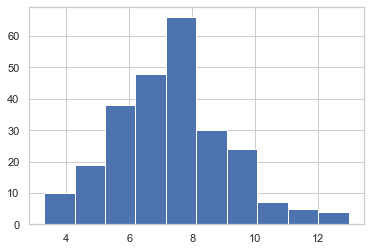

In [236]:
x = df1['statistics.viewCount']
np.log(x).hist()

In [256]:
df1[df1['statistics.viewCount']==str(x.max())]

C:\Users\Shiva\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt


In [257]:
isML = tagsds.str.contains(pat='machine learning', regex=False)
isML

0      True
1       NaN
2     False
3     False
4     False
      ...  
46     True
47    False
48    False
49    False
0     False
Name: snippet.tags, Length: 251, dtype: object

In [284]:
MLdf = df1[isML==True]
notMLdf = df1[isML==False]
MLdf['statistics.viewCount'] = np.log(MLdf['statistics.viewCount'])
MLdf['statistics.viewCount']
notMLdf['statistics.viewCount'] = np.log(notMLdf['statistics.viewCount'])
notMLdf['statistics.viewCount']

C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2      9.115920
3     12.349944
4      8.612140
7      7.804659
9      8.198639
        ...    
44     5.963579
47     5.805135
48     5.869297
49     6.133398
0      5.521461
Name: statistics.viewCount, Length: 194, dtype: float64

In [285]:
(isML==False).sum() + (isML==True).sum() + 13 # drops NaN

251

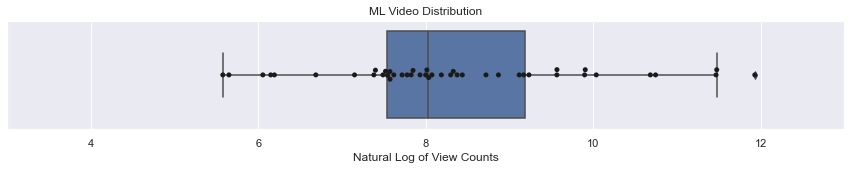

In [360]:
data = MLdf

sns.set(style='darkgrid')
plt.figure(figsize=(15,2))
ax = sns.boxplot(x='statistics.viewCount', data=data, orient='h')
ax = sns.swarmplot(x='statistics.viewCount', data=data, orient='h', color='0.1')
ax.set(xlim=(3,13))

ax.set(xlabel='Natural Log of View Counts', title='ML Video Distribution', )
plt.show()

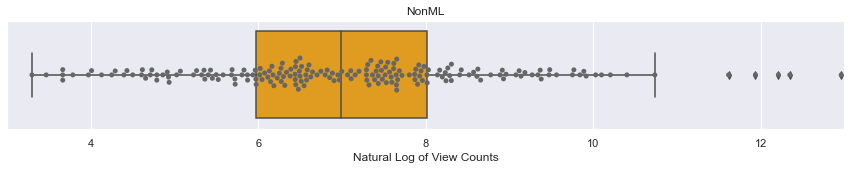

In [361]:
data = notMLdf

sns.set(style='darkgrid')
plt.figure(figsize=(15,2))
ax = sns.boxplot(x='statistics.viewCount', data=data, orient='h', color='orange')
ax = sns.swarmplot(x='statistics.viewCount', data=data, orient='h',color='0.4')
ax.set(xlim=(3,13))

ax.set(xlabel='Natural Log of View Counts', title='NonML', )
plt.show()

In [306]:
data = [MLdf['statistics.viewCount'], notMLdf['statistics.viewCount']]

sns.set(style='dark')
ax = sns.boxplot(x, data=data, orient='h')
ax = sns.swarmplot(x, data=data, orient='h')
ax.set(xlabel='Natural Log of View Counts',ylabel='Video Type', title='Comparing distribution of Video Types', )
plt.show()

AttributeError: 'list' object has no attribute 'get'